In this notebook we take the **Concrete Compressive Strength** Data Set from UCI Machine Learning Repository and walk through some exploratory steps for building an ML model. The data has 7 component features (all measured in density $\frac{kg}{m^3}$) that make up the concrete mixtures, plus their age (days) and the target variable itself **compressive strength** measurd in Mega-Pascals (MPa).

**Pre-Work Done:**
- Renamed columns (e.g **_Cement (component 1)(kg in a m^3 mixture)_** &rarr; **_cement_**
- Added mixture_uuid primary key
- Added 2 features { ratio_water_cement, ratio_coarse_fine_agg }
    - Found these from literature
    - Explicitely including them as features significantly reduced model error
- Added csv to local Postgres server
- Sampled db_table to create test_table & train_table

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import sys
import pandas as pd
import numpy as np
import psycopg2

from utils import config
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import seaborn as sb
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Get Data From Postgres

In [3]:
# Obtain the configuration parameters
params = config()
# Connect to the PostgreSQL database
conn = psycopg2.connect(**params)
# Create a cursor object
cur = conn.cursor()

sql_table_summary = '''
WITH row_counts AS (
   SELECT 
    '1. full data' AS category
    , COUNT(*) AS num_rows
   FROM concrete_data
 UNION
   SELECT 
    '2. train data' AS category
    , COUNT(*) AS num_rows
   FROM concrete_train_data
 UNION
   SELECT 
    '3. test data' AS category
    , COUNT(*) AS num_rows
   FROM concrete_test_data
)

SELECT
  category
  , num_rows
  , ROUND((num_rows::float / (MAX(num_rows) OVER()))::decimal,2) AS pct
FROM row_counts
ORDER BY category;
'''

print(sql_table_summary)
pd.read_sql_query(sql_table_summary, conn)


WITH row_counts AS (
   SELECT 
    '1. full data' AS category
    , COUNT(*) AS num_rows
   FROM concrete_data
 UNION
   SELECT 
    '2. train data' AS category
    , COUNT(*) AS num_rows
   FROM concrete_train_data
 UNION
   SELECT 
    '3. test data' AS category
    , COUNT(*) AS num_rows
   FROM concrete_test_data
)

SELECT
  category
  , num_rows
  , ROUND((num_rows::float / (MAX(num_rows) OVER()))::decimal,2) AS pct
FROM row_counts
ORDER BY category;



,category,num_rows,pct
0,1. full data,1030,1.0
1,2. train data,824,0.8
2,3. test data,206,0.2


### Explore Dataset

In [4]:
# Query the training / test data
sql_train = '''
	SELECT
		-- mixture_uuid,
		cement,
		blast_furnace_slag,
		fly_ash,
		water,
		superplasticizer,
		coarse_aggregate,
		fine_aggregate,
		age,
		ratio_water_cement,
		ratio_coarse_fine_agg,
		concrete_compressive_strength
	FROM concrete_train_data;
'''

sql_test = '''
	SELECT
		-- mixture_uuid,
		cement,
		blast_furnace_slag,
		fly_ash,
		water,
		superplasticizer,
		coarse_aggregate,
		fine_aggregate,
		age,
		ratio_water_cement,
		ratio_coarse_fine_agg,
		concrete_compressive_strength
	FROM concrete_test_data;
'''

train = pd.read_sql_query(sql_train, conn)
test = pd.read_sql_query(sql_test, conn)

# Close connection
cur.close()
conn.close()

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cement                         824 non-null    float64
 1   blast_furnace_slag             824 non-null    float64
 2   fly_ash                        824 non-null    float64
 3   water                          824 non-null    float64
 4   superplasticizer               824 non-null    float64
 5   coarse_aggregate               824 non-null    float64
 6   fine_aggregate                 824 non-null    float64
 7   age                            824 non-null    int64  
 8   ratio_water_cement             824 non-null    float64
 9   ratio_coarse_fine_agg          824 non-null    float64
 10  concrete_compressive_strength  824 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 70.9 KB


_Histograms are a quick and easy way (when the data is small enough) to understand the distribution of your data and check for any outliers._

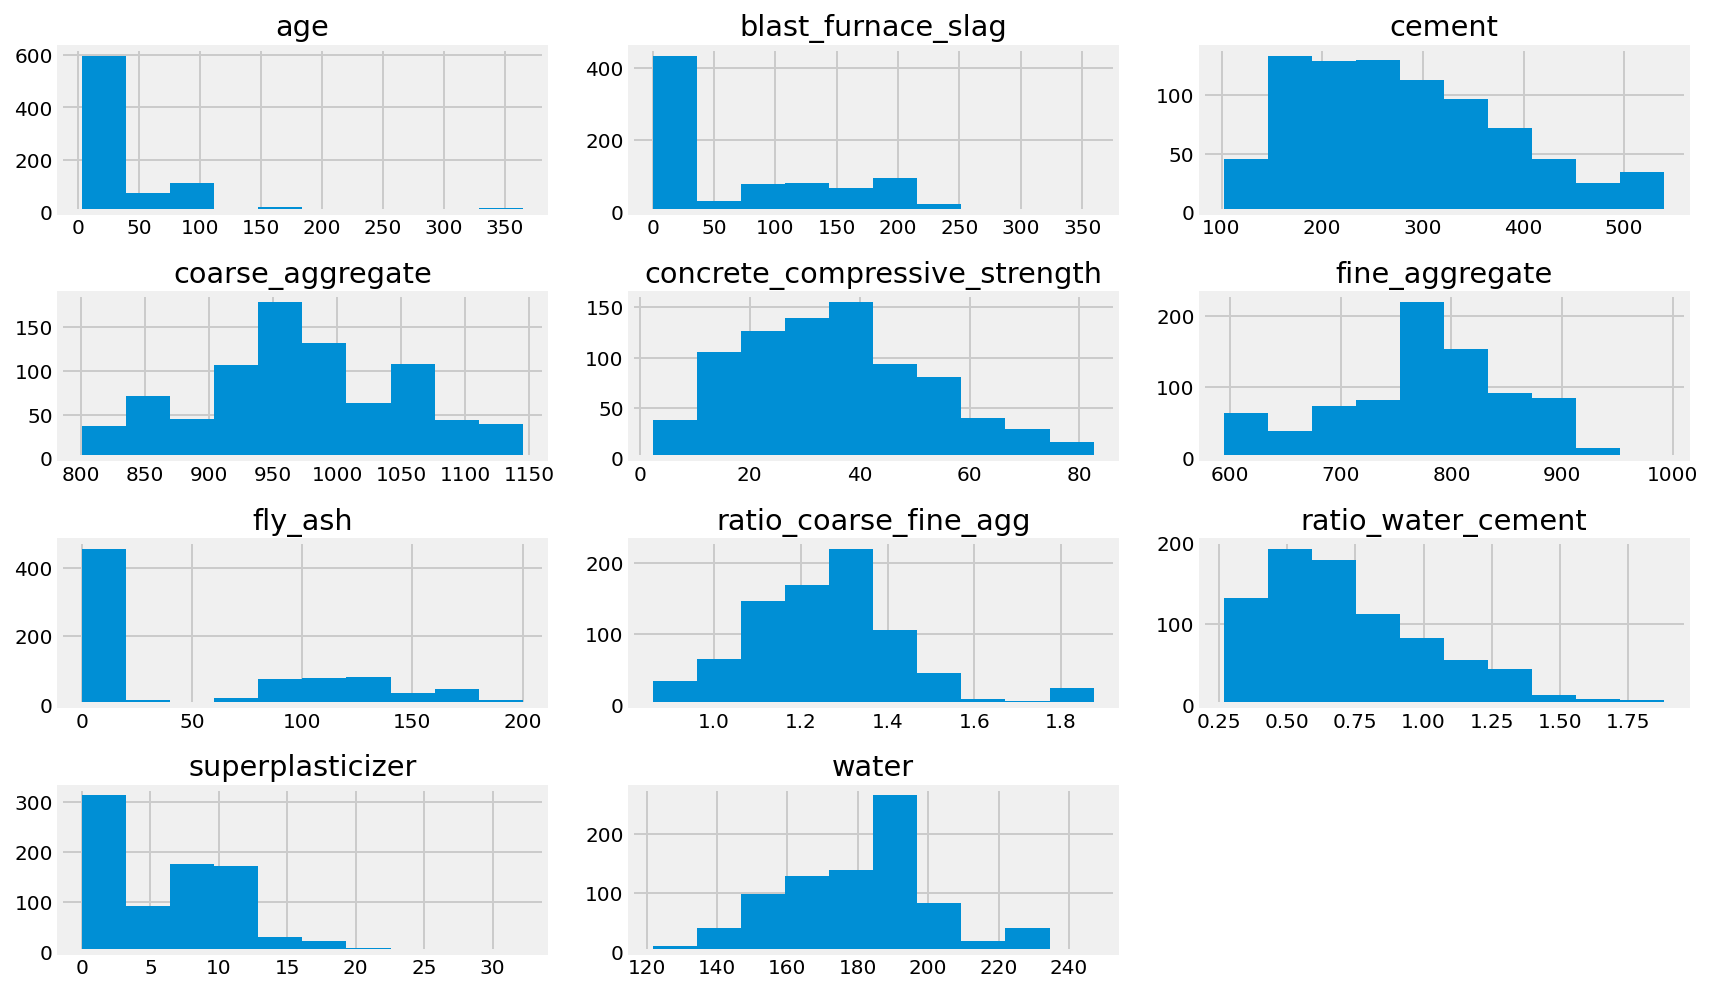

In [6]:
train.hist(figsize=(12,7))
plt.tight_layout()
plt.show()

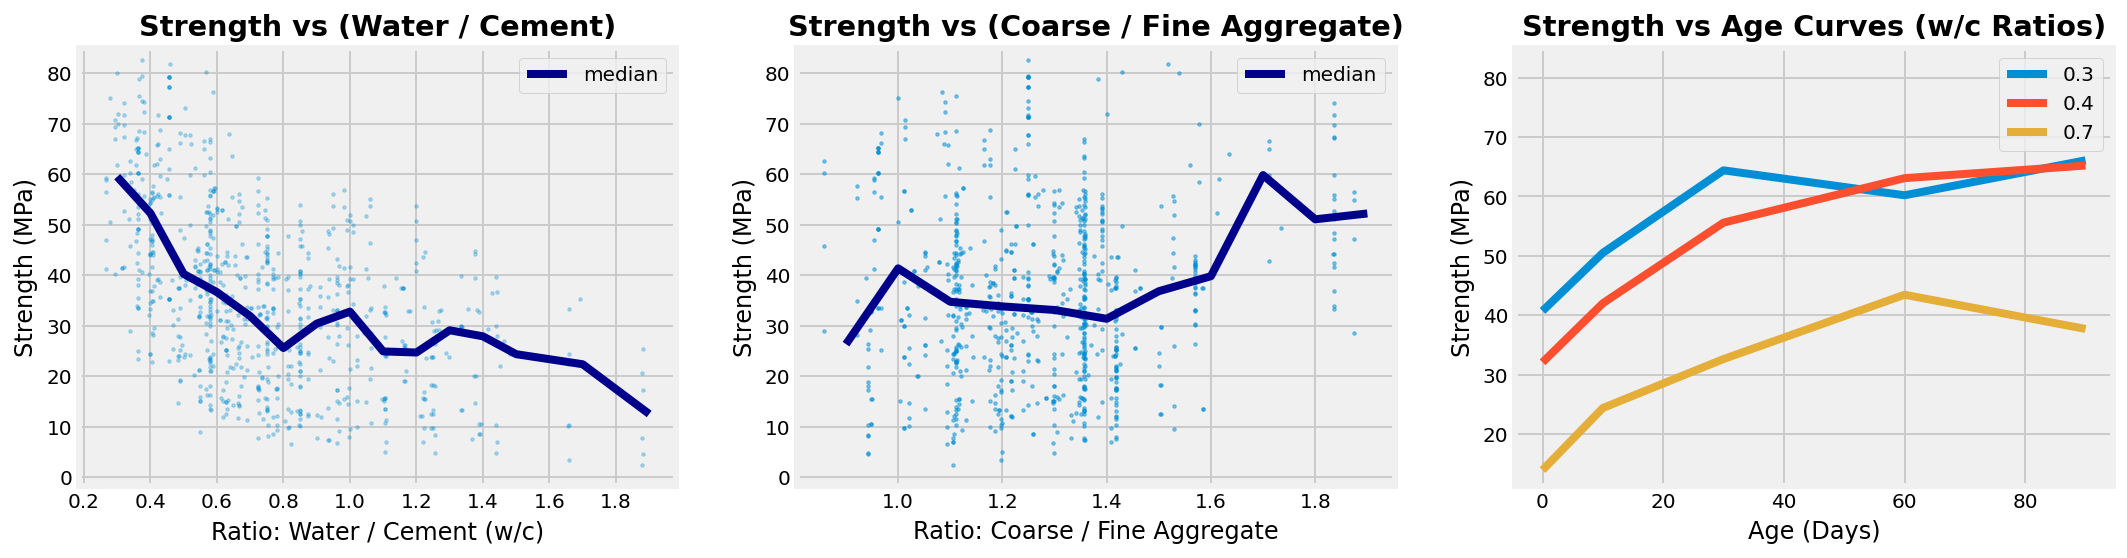

In [7]:
# temp_df for graphing
temp_df = pd.DataFrame({
    'wc_ratio': train['ratio_water_cement'].apply(lambda x: round(x * 10, 0) / 10 ),
    'coarse_fine_ratio': train['ratio_coarse_fine_agg'].apply(lambda x: round(x * 10, 0) / 10 ),
    'age': train['age'].apply(lambda x: round(x / 10) * 10),
    'strength': train['concrete_compressive_strength'],
})


# Plotting params
plot_params = {
    0: {
        'ylim_top': 85,
        'title': 'Strength vs (Water / Cement)',
        'ylabel': 'Strength (MPa)',
        'xlabel': 'Ratio: Water / Cement (w/c)',
    }
    ,
    1: {
        'ylim_top': 85,
        'title': 'Strength vs (Coarse / Fine Aggregate)',
        'ylabel': 'Strength (MPa)',
        'xlabel': 'Ratio: Coarse / Fine Aggregate',
    }
    ,
    2: {
        'ylim_top': 85,
        'title': 'Strength vs Age Curves (w/c Ratios)',
        'ylabel': 'Strength (MPa)',
        'xlabel': 'Age (Days)',
    },
}


fig, ax = plt.subplots(1, 3, figsize=(15,4), sharey=False)

# FIRST SUBPLOT 'Strength vs (Water / Cement)'
wc_vs_strength = temp_df\
    .groupby(by=['wc_ratio'])['strength']\
    .median()\
    .reset_index(drop=False)

ax[0].plot(wc_vs_strength['wc_ratio'], wc_vs_strength['strength'], c='darkblue', label='median',)
ax[0].scatter(
    x=(train['ratio_water_cement']), 
    y=train['concrete_compressive_strength'], 
    s=3,
    alpha=0.30,
)


# SECOND SUBPLOT 'Strength vs (Coarse / Fine Aggregate)'
coarse_fine_vs_strength = temp_df\
    .groupby(by=['coarse_fine_ratio'])['strength']\
    .median()\
    .reset_index(drop=False)

ax[1].plot(coarse_fine_vs_strength['coarse_fine_ratio'], coarse_fine_vs_strength['strength'], c='darkblue', label='median',)
ax[1].scatter(
    x=(train['ratio_coarse_fine_agg']), 
    y=train['concrete_compressive_strength'], 
    s=3,
    alpha=0.50,
)

# THIRD SUBPLOT 'Strength vs Age Curves (w/c Ratios)'
mask = ((temp_df['wc_ratio'].isin([0.3, 0.4, 0.7])) & (temp_df['age'] <= 90))

groups = temp_df[mask].groupby(by=['wc_ratio', 'age'])['strength']\
    .median()\
    .reset_index(drop=False)\
    .groupby(by='wc_ratio')

for name, group in groups:
    ax[2].plot(group['age'], group['strength'], ms=12, label=name)

for idx, params in plot_params.items():
    ax[idx].set_ylim(top=params['ylim_top'])
    ax[idx].set_ylabel(params['ylabel'])
    ax[idx].set_xlabel(params['xlabel'])
    ax[idx].set_title(params['title'], fontweight='bold')
    ax[idx].grid(True)
    ax[idx].legend()

plt.tight_layout()
plt.show()

### Use Cross Validation on Training Data

_Here we're evaluating a simple Linear Regression model versus a Random Forest Regressor via cross validation. Scoring metric of interest: Mean Squared Error_

In [8]:
# Assign X,y train
X_train = train.drop(['concrete_compressive_strength'], axis=1)
y_train = train['concrete_compressive_strength']

# Assign X,y test
X_test = test.drop(['concrete_compressive_strength'], axis=1)
y_test = test['concrete_compressive_strength']

In [9]:
models_dict = {
    'LinearRegression': {
        'Estimator': LinearRegression(fit_intercept=True),
        'cv_scores': None,
        'mean_cv_score': None,
        'std_cv_score': None,
    },
    'RandomForestRegressor': {
        'Estimator': RandomForestRegressor(
            n_estimators=10, 
            criterion='mse', 
            max_features='sqrt'
        ),
        'cv_scores': None,
        'mean_cv_score': None,
        'std_cv_score': None,
    },
}

for name, model_params in models_dict.items():
    scores = cross_val_score(
        estimator=model_params['Estimator'],
        X=X_train,
        y=y_train,
        cv=3, 
        scoring='neg_mean_squared_error',
    )
    
    scores *= -1
    model_params['cv_scores'] = scores
    model_params['mean_cv_score'] = scores.mean()
    model_params['std_cv_score'] = scores.std()
    
results = [
    (j, round(k['mean_cv_score'],3), round(k['std_cv_score'],3)) \
    for (j, k) in models_dict.items()
]

winner = sorted(results, key=lambda tup: tup[1])[0]
print('Best Estimator: {}'.format(winner[0]))
print('Mean Squared Error = ({:.2f} +/- {:.2f})'.format(winner[1], winner[2]))

Best Estimator: RandomForestRegressor
Mean Squared Error = (35.20 +/- 8.89)


In [10]:
results

[('LinearRegression', 106.092, 9.318),
 ('RandomForestRegressor', 35.197, 8.889)]

### Evaluate Model on Holdout Set

In [11]:
model = Pipeline(steps=[
    ('normalize', StandardScaler()), 
    ('rf', models_dict[winner[0]]['Estimator'])
])

model.fit(
    X=X_train,
    y=y_train
)

y_hat = model.predict(X_test)

mse = mean_squared_error(y_true=y_test, y_pred=y_hat)
print('Validation Set MSE: %.3f' % mse)

Validation Set MSE: 26.175


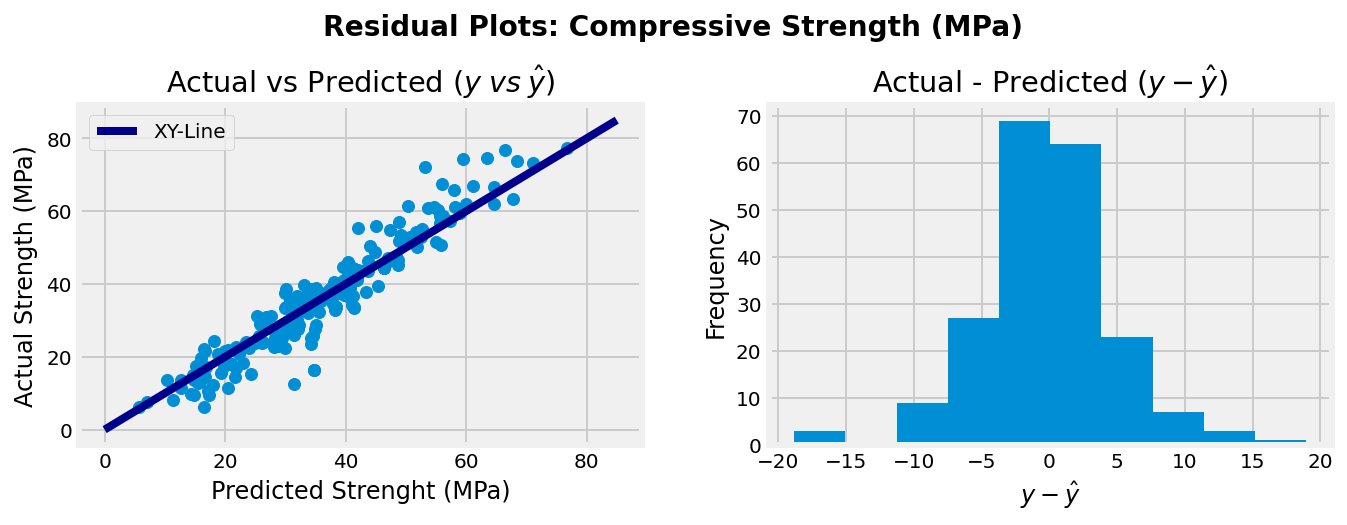

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=False)
fig.suptitle('Residual Plots: Compressive Strength (MPa)', fontsize=14, fontweight='bold')

xy_line = np.linspace(start=0, stop=85, num=200)
ax[0].scatter(y_hat, y_test)
ax[0].plot(xy_line, xy_line, c='darkblue', label='XY-Line')
ax[0].set_title('Actual vs Predicted ' +  r'$(y \;vs\; \hat{y})$')
ax[0].set_xlabel('Predicted Strenght (MPa)')
ax[0].set_ylabel('Actual Strength (MPa)')
ax[0].legend()
ax[0].grid(True)

ax[1].hist(y_test - y_hat)
ax[1].set_title('Actual - Predicted ' +  r'$(y - \hat{y})$')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel(r'$y - \hat{y}$')
ax[1].grid(True)

plt.tight_layout(pad=3)
plt.show()

_One of the benefits of using tree based methods is the ability to extract **feature importance** from the fitted model (see below). Note the relatively high ranking of We see the Water / Cement Ratio, which was not a feature in the original dataset_

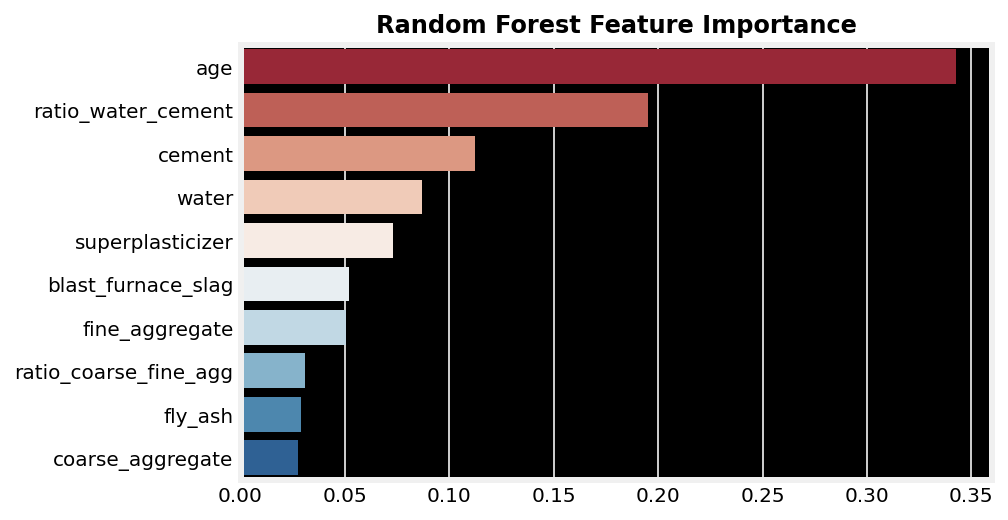

In [13]:
model_name = 'Random Forest'
feature_importance = model['rf'].feature_importances_

sorted_features = feature_importance[np.argsort(feature_importance)]

plt.figure(figsize = (6,4))
plt.rcParams['axes.facecolor'] = 'black'
plt.title('{} Feature Importance'.format(model_name), fontsize=12, fontweight='bold')
sb.barplot(
    sorted_features[::-1], 
    X_train.columns[np.argsort(feature_importance)][::-1], 
    palette="RdBu"
);